In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dropout, Dense, Flatten, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Conv2D, MaxPool2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception

import cv2

from tqdm import tqdm
import os
import gc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings("ignore")

In [2]:
images = []
labels = []

main_directory = '/animals'

for animal in tqdm(os.listdir(main_directory)):
    for i in range(len(os.listdir(main_directory + '/' + animal))):
        if i < 30:
            img = cv2.imread(main_directory + '/' + animal + '/' + os.listdir(main_directory + '/' + animal)[i])
            resized_img = cv2.resize(img,(224,224))
            resized_img = resized_img / 255.0
            images.append(resized_img)
            labels.append(animal)

images = np.array(images,dtype = 'float32')

100%|██████████| 90/90 [00:43<00:00,  2.09it/s]


In [3]:
le = preprocessing.LabelEncoder()
le.fit(labels)
class_names = le.classes_
labels = le.transform(labels)

labels = np.array(labels, dtype = 'uint8')
labels = np.resize(labels, (len(labels),1))

In [4]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.33, stratify = labels)

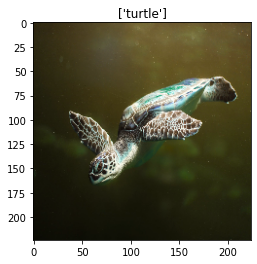

In [5]:
n = np.random.randint(0,np.shape(train_images)[0])

plt.imshow(train_images[n])
plt.title(str(le.inverse_transform([train_labels[n]])))
plt.show()

In [6]:
inception_model = Sequential()

inception_base_model = InceptionV3(include_top = False, input_shape = (224,224,3))
    
inception_model.add(inception_base_model)

inception_model.add(GlobalAveragePooling2D())

inception_model.add(Dense(units = 90, activation = 'softmax'))

inception_model.summary()

early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 20,restore_best_weights = True,verbose = 0)

# Compile
inception_model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.0001) , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

# Train
inception = inception_model.fit(train_images, train_labels, batch_size = 32, epochs = 5, callbacks = [early_stopping], validation_split = 0.2)

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 90)                184410    
Total params: 21,987,194
Trainable params: 21,952,762
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/5
46/46 [==============================] - 27s 216ms/step - loss: 3.2174 - accuracy: 0.3670 - val_loss: 1.5691 - val_accuracy: 0.5994
Epoch 2/5
46/46 [==============================] - 8s 166ms/step - loss: 0.8766 - accuracy: 0.8915 - val_loss: 1.1535 - val_accuracy: 0.7099
Epoch 3/5
46/46 [====

In [7]:
inception_predictions = inception_model.predict(test_images)
inception_predictions = np.argmax(inception_predictions,axis = 1)

In [8]:
xception_model = Sequential()

xception_base_model = Xception(include_top = False, input_shape = (224,224,3))

xception_model.add(xception_base_model)

xception_model.add(GlobalAveragePooling2D())

xception_model.add(Dense(units = 90, activation = 'softmax'))

xception_model.summary()

early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 20,restore_best_weights = True,verbose = 0)

# Compile
xception_model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.0001) , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

# Train
xception = xception_model.fit(train_images, train_labels, batch_size = 32, epochs = 5, callbacks = [early_stopping], validation_split = 0.2)

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                184410    
Total params: 21,045,890
Trainable params: 20,991,362
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/5
46/46 [==============================] - 28s 434ms/step - loss: 3.8460 - accuracy: 0.3089 - val_loss: 2.7671 - val_accuracy: 0.4696
Epoch 2/5
46/46 [==============================] - 18s 396ms/step - loss: 1.9764 - accuracy: 0.8459 - val_loss: 1.6178 - val_accuracy: 0.7044
Epoch 3/5
46/46 [=

In [9]:
xception_predictions = xception_model.predict(test_images)
xception_predictions = np.argmax(xception_predictions,axis = 1)

In [10]:
alex_model = Sequential()

alex_model.add(Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), activation = 'relu', input_shape = (224,224,3)))
alex_model.add(BatchNormalization())
alex_model.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))

alex_model.add(Conv2D(filters = 256, kernel_size = (5,5), strides = (1,1), activation = 'relu', padding = 'same'))
alex_model.add(BatchNormalization())
alex_model.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))

alex_model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'))
alex_model.add(BatchNormalization())

alex_model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'))
alex_model.add(BatchNormalization())

alex_model.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'))
alex_model.add(BatchNormalization())
alex_model.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))

alex_model.add(Flatten())

alex_model.add(Dense(units = 4096, activation = 'relu'))
alex_model.add(Dropout(0.5))

alex_model.add(Dense(units = 4096, activation = 'relu'))
alex_model.add(Dropout(0.5))

alex_model.add(Dense(units = 90, activation = 'softmax'))

early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 20,restore_best_weights = True,verbose = 0)

# Compile
alex_model.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

alex_model.summary()

# Train
alex = alex_model.fit(train_images, train_labels, batch_size = 32, epochs = 5, callbacks = [early_stopping], validation_split = 0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization_98 (Batc (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_99 (Batc (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 12, 12, 384)      

In [11]:
alex_predictions = alex_model.predict(test_images)
alex_predictions = np.argmax(alex_predictions,axis = 1)

In [12]:
vgg_model = Sequential()

vgg_base_model = VGG16(include_top = False, weights="imagenet", input_shape = (224,224,3))
print(f'Number of layers in VGG16 : {len(vgg_base_model.layers)}')

vgg_base_model.trainable = True

for layer in vgg_base_model.layers[:10]:
    layer.trainable = False

vgg_model.add(vgg_base_model)

vgg_model.add(GlobalAveragePooling2D())

vgg_model.add(Dense(units = 90, activation = 'softmax'))

vgg_model.summary()

early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 20,restore_best_weights = True,verbose = 0)

# Compile
vgg_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001) , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

# Train
vgg = vgg_model.fit(train_images, train_labels, batch_size = 32, epochs = 5, callbacks = [early_stopping], validation_split = 0.2)

58900480/58889256 [==============================] - 3s 0us/step
Number of layers in VGG16 : 19
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 90)                46170     
Total params: 14,760,858
Trainable params: 13,025,370
Non-trainable params: 1,735,488
_________________________________________________________________
Epoch 1/5
46/46 [==============================] - 12s 174ms/step - loss: 4.5350 - accuracy: 0.0083 - val_loss: 4.4998 - val_accuracy: 0.0110
Epoch 2/5
46/46 [==============================] - 5s 115ms/step - loss: 4.5001 - accuracy: 0.0111 - val_loss: 4.5003 - val_ac

In [13]:
vgg_predictions = vgg_model.predict(test_images)
vgg_predictions = np.argmax(vgg_predictions,axis = 1)

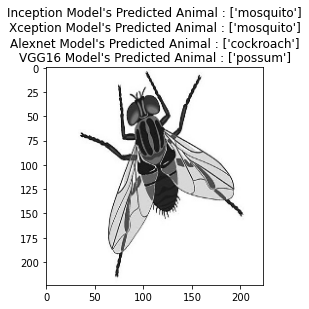

In [14]:
n = np.random.randint(0,np.shape(test_images)[0])

plt.imshow(test_images[n])
plt.title("Inception Model's Predicted Animal : " + str(le.inverse_transform([inception_predictions[n]])) + '\n' + "Xception Model's Predicted Animal : " + str(le.inverse_transform([xception_predictions[n]])) + '\n' + "Alexnet Model's Predicted Animal : " + str(le.inverse_transform([alex_predictions[n]])) + '\n' + "VGG16 Model's Predicted Animal : " + str(le.inverse_transform([vgg_predictions[n]])))
plt.show()

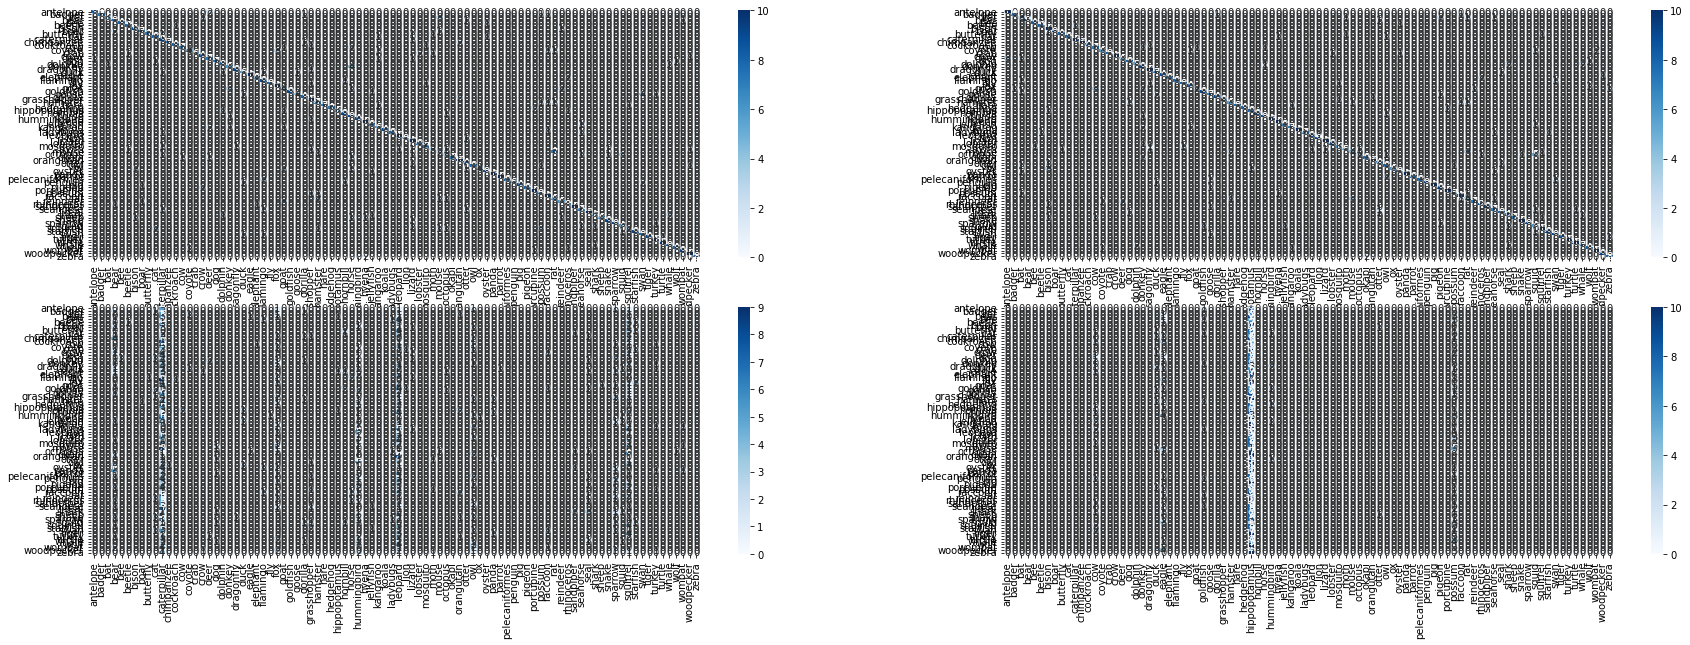

In [15]:
inception_cm = confusion_matrix(test_labels, inception_predictions)
xception_cm = confusion_matrix(test_labels, xception_predictions)
alex_cm = confusion_matrix(test_labels, alex_predictions)
vgg_cm = confusion_matrix(test_labels, vgg_predictions)

plt.figure(figsize = (30,10))

plt.subplot(2,2,1)
sns.heatmap(inception_cm,cmap = 'Blues',annot = True, xticklabels = class_names, yticklabels = class_names)

plt.subplot(2,2,2)
sns.heatmap(xception_cm,cmap = 'Blues',annot = True, xticklabels = class_names, yticklabels = class_names)

plt.subplot(2,2,3)
sns.heatmap(alex_cm,cmap = 'Blues',annot = True, xticklabels = class_names, yticklabels = class_names)

plt.subplot(2,2,4)
sns.heatmap(vgg_cm,cmap = 'Blues',annot = True, xticklabels = class_names, yticklabels = class_names)

plt.show()

In [16]:
def scores(cm):
    p = {}
    r = {}
    f1 = {}
    
    for i in range(len(cm)):
        p[i] = cm[i,i] / sum(cm[:,i])
        r[i] = cm[i,i] / sum(cm[i,:])
        f1[i] = 2 * (cm[i,i] / sum(cm[:,i])) * (cm[i,i]/sum(cm[i,:])) / ((cm[i,i] / sum(cm[:,i])) + (cm[i,i]/sum(cm[i,:])))
    
    return p,r,f1     

In [17]:
i_p,i_r,i_f1 = scores(inception_cm)
x_p,x_r,x_f1 = scores(xception_cm)
a_p,a_r,a_f1 = scores(alex_cm)
v_p,v_r,v_f1 = scores(vgg_cm)

In [18]:
Precision = {
    'Inception Precision' : i_p,
    'Xception Precision' : x_p,
    'AlexNet Precision' : a_p,
    'VGG16 Precision' : v_p
}

Precision = pd.DataFrame(Precision)
Precision

,Inception Precision,Xception Precision,AlexNet Precision,VGG16 Precision
0,0.888889,0.769231,NaN,NaN
1,1.000000,0.888889,NaN,NaN
2,0.857143,0.333333,NaN,NaN
3,0.727273,0.818182,0.0,NaN
4,1.000000,0.888889,0.0,NaN
...,...,...,...,...
85,0.750000,0.700000,NaN,NaN
86,0.888889,0.800000,0.0,NaN
87,0.900000,0.833333,0.0,NaN
88,0.769231,0.900000,NaN,NaN


In [19]:
Recall = {
    'Inception Recall' : i_r,
    'Xception Recall' : x_r,
    'AlexNet Recall' : a_r,
    'VGG16 Recall' : v_r
}

Recall = pd.DataFrame(Recall)

Recall

,Inception Recall,Xception Recall,AlexNet Recall,VGG16 Recall
0,0.8,1.0,0.0,0.0
1,0.7,0.8,0.0,0.0
2,0.6,0.3,0.0,0.0
3,0.8,0.9,0.0,0.0
4,0.8,0.8,0.0,0.0
...,...,...,...,...
85,0.9,0.7,0.0,0.0
86,0.8,0.8,0.0,0.0
87,0.9,1.0,0.0,0.0
88,1.0,0.9,0.0,0.0


In [20]:
F1_score = {
    'Inception F1_score' : i_f1,
    'Xception F1_score' : x_f1,
    'AlexNet F1_score' : a_f1,
    'VGG16 F1_score' : v_f1
}

F1_score = pd.DataFrame(F1_score)
F1_score

,Inception F1_score,Xception F1_score,AlexNet F1_score,VGG16 F1_score
0,0.842105,0.869565,NaN,NaN
1,0.823529,0.842105,NaN,NaN
2,0.705882,0.315789,NaN,NaN
3,0.761905,0.857143,NaN,NaN
4,0.888889,0.842105,NaN,NaN
...,...,...,...,...
85,0.818182,0.700000,NaN,NaN
86,0.842105,0.800000,NaN,NaN
87,0.900000,0.909091,NaN,NaN
88,0.869565,0.900000,NaN,NaN


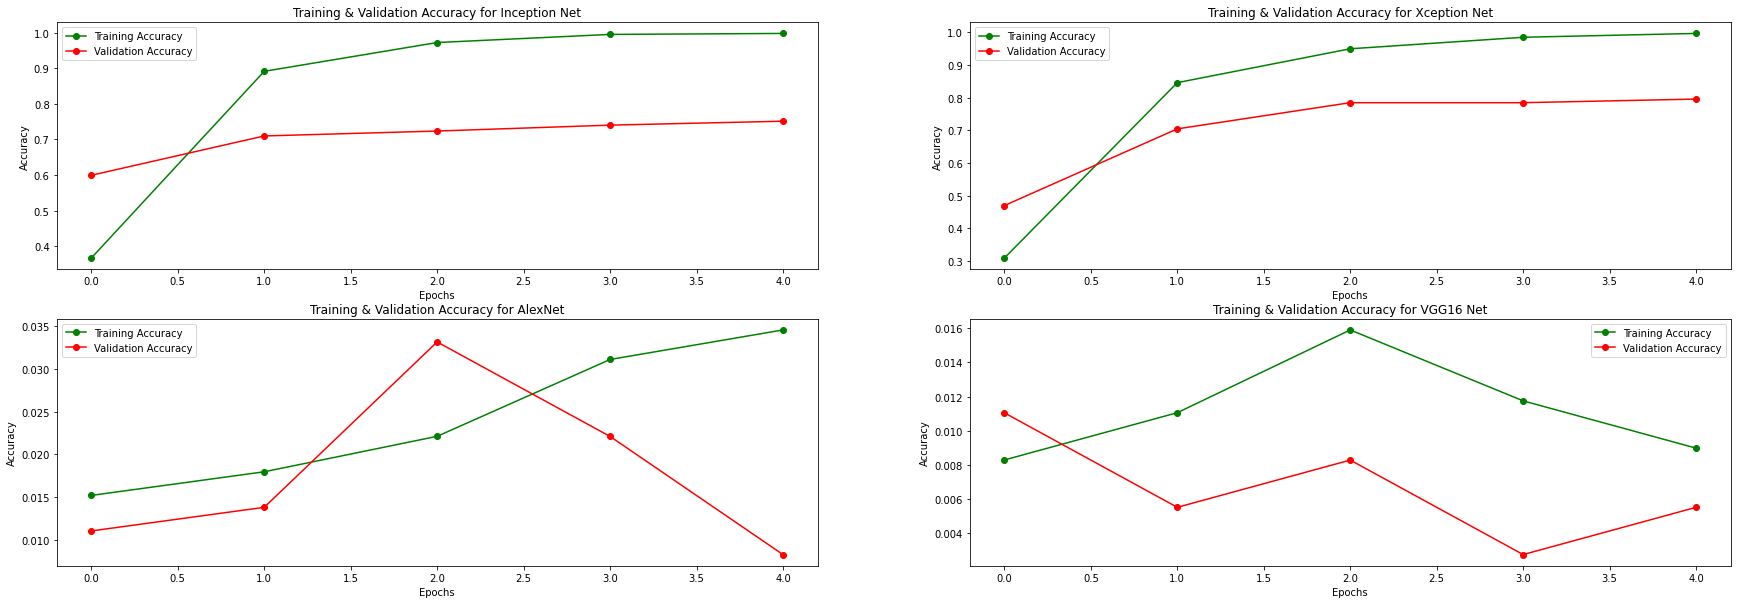

In [21]:
plt.figure(figsize = (30,10))

plt.subplot(2,2,1)
i_train_acc = inception.history['accuracy']
i_val_acc = inception.history['val_accuracy']
i_epoch = [i for i in range(len(i_val_acc))]
plt.plot(i_epoch , i_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for Inception Net')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,2)
x_train_acc = xception.history['accuracy']
x_val_acc = xception.history['val_accuracy']
x_epoch = [i for i in range(len(x_val_acc))]
plt.plot(x_epoch , x_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(x_epoch , x_val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for Xception Net')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
x_train_acc = alex.history['accuracy']
x_val_acc = alex.history['val_accuracy']
x_epoch = [i for i in range(len(x_val_acc))]
plt.plot(x_epoch , x_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(x_epoch , x_val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for AlexNet')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,4)
x_train_acc = vgg.history['accuracy']
x_val_acc = vgg.history['val_accuracy']
x_epoch = [i for i in range(len(x_val_acc))]
plt.plot(x_epoch , x_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(x_epoch , x_val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for VGG16 Net')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()